# Walk forward analysis - Part 2 - Predicting the args for OOS periods

* In the other notebook in this repo. labelled "Part 1", we built a script combining OOS periods to perform WFA using data exported from TradingView.

* One of the parameters in my NQ strategy - called "Brick" - acts as a filter to prevent trades from taking place if ATR is below the inputted threshold. Logically, the optimal value should correlate with expected market volatility. Although we don't have a crystal ball to quantify realized volatility, it still makes sense to use VIX as a predictor.

To train the model, we feed weekly VIX and performance benchmarks (refer to previous script) and apply a linear regression model to fit the training data set. One question we need to address is the appropriate window size for training. This question will be addressed in the "Model Selection" section of this notebook.

In [10]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt  
import numpy as np
from sklearn.model_selection import learning_curve

In [11]:
DO_NORM = False 

## Loading the data

From [previous notebook](https://github.com/kevinhhl/Pinescript-Projects/blob/5ca8a0b4ef847159ae93bfedb3cf8c7a67b3d3a1/Backtesting%20frameworks/Walk%20Forward%20Analysis%20V1.ipynb):

In [12]:
df_wfa_template = pd.read_pickle('output_wfa.pkl')
df_wfa_template.tail()

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,benchmark,OOS Date1,OOS Date2,OOS ATR,OOS Brick
475,2023_Week #36,2023-09-04,2023-09-10,29,2,-31.4,2023-09-11,2023-09-17,2.0,24.0
476,2023_Week #37,2023-09-11,2023-09-17,17,2,-3.7,2023-09-18,2023-09-24,2.0,23.0
477,2023_Week #38,2023-09-18,2023-09-24,24,2,-13.5,2023-09-25,2023-10-01,2.0,24.0
478,2023_Week #39,2023-09-25,2023-10-01,29,2,-70.1,2023-10-02,2023-10-08,2.0,25.0
479,2023_Week #40,2023-10-02,2023-10-08,19,2,18.2,2023-10-09,2023-10-15,2.0,25.0


In [13]:
def _categorize_in_sample(date):
    ''' Helper function to categorize in-sample group based on given date. '''
    year, week_num, day_of_week = date.isocalendar()
    return str(year) + "_Week #{:02d}".format(week_num)

df_vix = yf.download("^VIX", start="2014-01-01", end="2030-12-31")
df_vix.reset_index(inplace=True)
df_vix["Date"] = df_vix["Date"].apply(_categorize_in_sample)
df_vix = df_vix.groupby("Date").mean()
df_vix.reset_index(inplace=True)
df_vix = df_vix[['Date', 'Close']]
df_vix.rename(columns={"Close": "Avg. VIX", "Date":"In-sample Period"}, inplace=True)
df_vix["Avg. VIX"] = df_vix["Avg. VIX"].shift(-1) # Shift Avg. VIX by 1 week to account for 1 week lag in data
df_vix.tail()

[*********************100%***********************]  1 of 1 completed


,In-sample Period,Avg. VIX
505,2023_Week #36,13.624
506,2023_Week #37,15.598
507,2023_Week #38,17.784
508,2023_Week #39,18.382
509,2023_Week #40,NaN


## Model Selection

To select the final model, we will use the Sci Kit Learn's learning_curve() to help use visualize training and validation errors under different scenarios of using different sample sizes for training. We use RMSE to measure magnitude of errors.

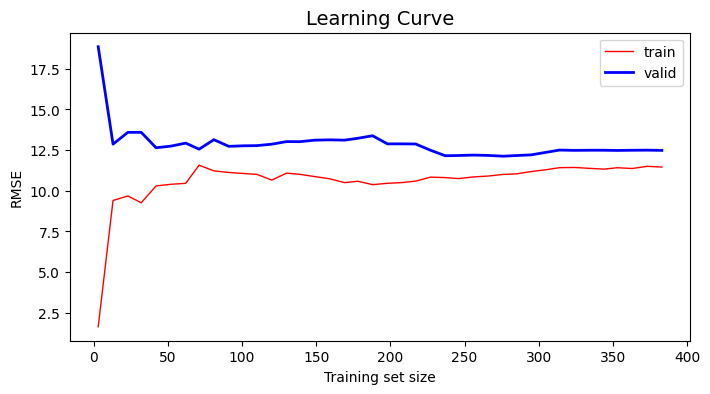

Training set size at which both curves converge:  276


In [14]:
# Prepare data for learning curve
df = df_wfa_template.copy()
df["Avg. VIX"] = df["In-sample Period"].map(df_vix.set_index("In-sample Period")["Avg. VIX"]) 
df = df[['In-sample Period', 'IS: Date1', 'IS: Date2', 'IS: Brick', 'IS: ATR', 'Avg. VIX']] 
_df = df.copy()
_df = df.dropna()
X_train = _df['Avg. VIX'].values.reshape(-1, 1)
y_train = _df['IS: Brick'].values.reshape(-1, 1)  
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

# Vectors of mean RMSE scores across folds, for each training set size
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1) 

# Plot the learning curves
fig = plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_errors, "r", linewidth=1, label="train")
plt.plot(train_sizes, valid_errors, "b", linewidth=2, label="valid")
plt.title("Learning Curve", size=14)
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend(loc="best")
plt.show()

# Print at where the both curves converge or crosses
final_lookback = train_sizes[np.argmin(valid_errors)]
print("Training set size at which both curves converge: ", final_lookback)


## Training our model

In [15]:
def _create_model(lookback, do_norm=False, verbose=False):
    ''' Helper function to create a the final linear regression model '''

    df = df_wfa_template.copy()[lookback:] 
    df["Avg. VIX"] = df["In-sample Period"].map(df_vix.set_index("In-sample Period")["Avg. VIX"]) 
    df = df[['In-sample Period', 'IS: Date1', 'IS: Date2', 'IS: Brick', 'IS: ATR', 'Avg. VIX']] #, 'OOS Date1', 'OOS Date2', 'OOS ATR', 'OOS Brick' ]]

    if verbose:
        print("Correlation between Avg. VIX (Weekly) and the IS: Brick: \n = {}".format(df[['IS: Brick', 'Avg. VIX']].corr().iloc[0, 1]))

    _df = df.copy()
    _df.set_index('IS: Date1', inplace=True) 

    # Create a linear regression model
    model = LinearRegression()
    _df = df.dropna()

    # Define the features and the target
    X_train = _df['Avg. VIX'].values.reshape(-1, 1)
    y_train = _df['IS: Brick'].values.reshape(-1, 1) 

    scaler = StandardScaler()
    if do_norm:
        # Normalize the data
        X_train = scaler.fit_transform(X_train)
        y_train = scaler.fit_transform(y_train)
    else:
        pass

    # Fit the model to the training data
    model.fit(X_train, y_train)

    return model, scaler, X_train, y_train, df 


final_model, final_scaler, final_X_train, final_y_train, final_df_wfa = _create_model(lookback=final_lookback, do_norm=DO_NORM)

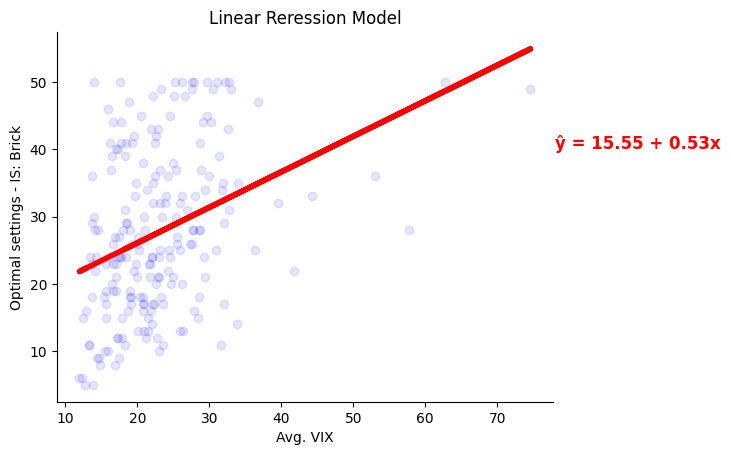

In [16]:
plt.scatter(final_X_train, final_y_train, color='blue', alpha=0.1)
plt.plot(final_X_train, final_model.predict(final_X_train), linewidth=4, color='red')
plt.xlabel('Avg. VIX')
plt.ylabel('Optimal settings - IS: Brick')
plt.title('Linear Reression Model') 
_hypo_funct = 'ŷ = {0:.2f} + {1:.2f}x'.format(final_model.intercept_[0], final_model.coef_[0][0])
plt.gca().spines['right'].set_visible(False),plt.gca().spines['top'].set_visible(False)
plt.text(1.005, 0.685, _hypo_funct, fontsize=12, transform=plt.gca().transAxes, color='red', fontweight='bold')
plt.show() 

In [17]:
final_df_wfa

,In-sample Period,IS: Date1,IS: Date2,IS: Brick,IS: ATR,Avg. VIX
276,2019_Week #46,2019-11-18,2019-11-24,5,2,12.714
277,2019_Week #47,2019-11-25,2019-12-01,6,2,11.945
278,2019_Week #48,2019-12-02,2019-12-08,8,2,14.762
279,2019_Week #49,2019-12-09,2019-12-15,9,2,14.620
280,2019_Week #50,2019-12-16,2019-12-22,15,2,12.404
...,...,...,...,...,...,...
475,2023_Week #36,2023-09-04,2023-09-10,29,2,13.624
476,2023_Week #37,2023-09-11,2023-09-17,17,2,15.598
477,2023_Week #38,2023-09-18,2023-09-24,24,2,17.784
478,2023_Week #39,2023-09-25,2023-10-01,29,2,18.382


## Prediction:

In [18]:
_last_vix = final_df_wfa.tail(1)['Avg. VIX'].iloc[0]

if np.isnan(_last_vix):
    final_df_wfa = final_df_wfa.dropna(subset=['Avg. VIX'])
    _last_vix = final_df_wfa.tail(1)['Avg. VIX'].iloc[0]

X_test = [[_last_vix]]

print("Based on Avg VIX = {:f}".format(X_test[0][0]))

if DO_NORM:
    prediction = final_scaler.inverse_transform(final_model.predict(X_test)).item()
else:
    prediction = final_model.predict(X_test).item() 

print("Prediction = {:f}".format(prediction))

Based on Avg VIX = 18.382000
Prediction = 25.250855
